In [39]:
#import modules
import pandas as pd
from sklearn.preprocessing import  LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifsier
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
random_seed = 42

In [40]:
#choose dataset and model from list
# datasets: 'census_income', 'bank_marketing', 'statlog_shuttle',  'diabetes',  'gsvs',
# models: 'lgbm', 'rf', 'svm'
model_name = 'lgbm'
dataset = 'census_income'
df = pd.read_csv(f'{dataset}.csv')

In [41]:
# encode categorical features
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
label_encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])
df.rename(columns={df.columns[-1]: 'label'}, inplace=True)

# convert multivariate modules to binary class data
if dataset == 'census_income':
    df['label'].replace({1: 0,2:0,3:1}, inplace = True)
elif dataset == 'gsvs':
    df['label'].replace({0:1, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}, inplace = True)
elif dataset == 'statlog_shuttle':
    df['label'].replace({1: 0,4:1,5:0,3:0,2:0,7:0,6:0}, inplace = True)

In [42]:
X = df.drop('label', axis=1)
y = df['label']

<Figure size 640x480 with 0 Axes>

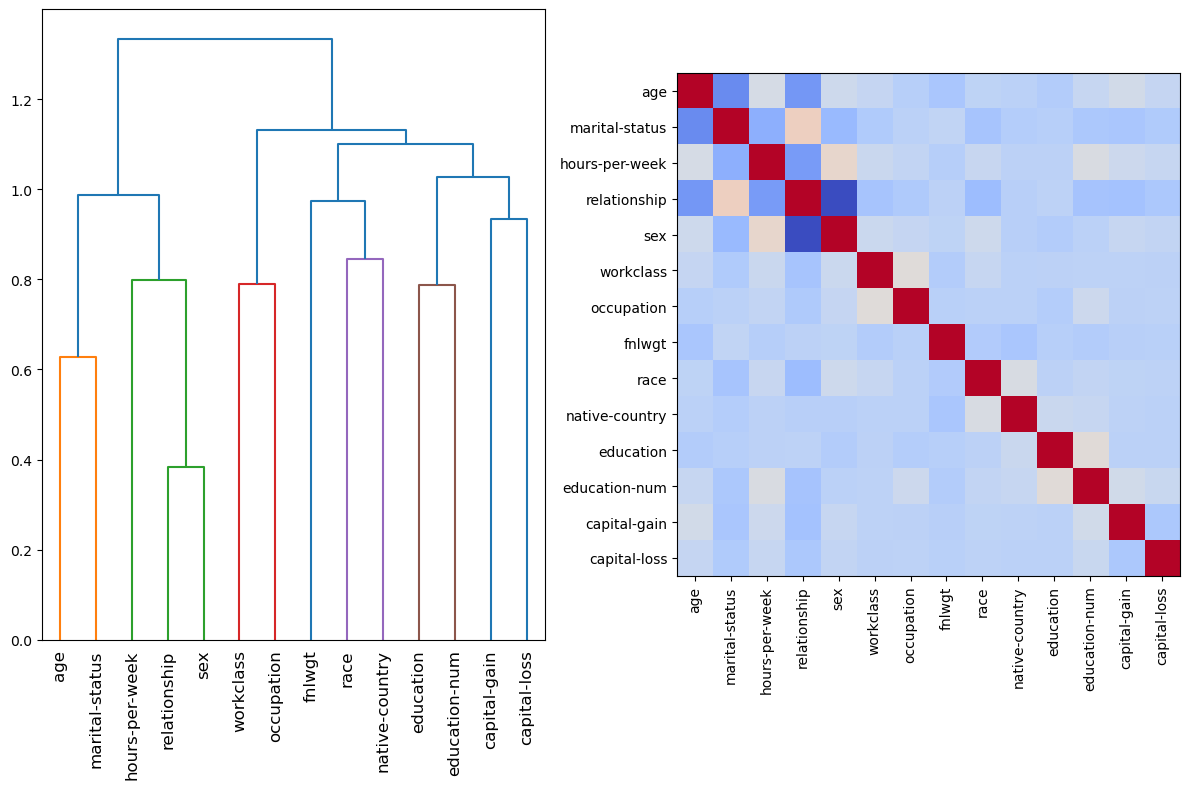

In [46]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Enforce symmetry on correlation matrix
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert the correlation matrix to a distance matrix and perform hierarchical clustering using Ward's linkage
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]], cmap='coolwarm')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
# plt.clf() #uncomment to hide plot
# plt.close() #uncomment to hide plot

## Step 1

In [33]:
# select threshold from visual inspection of hierarchical cluster
if dataset == 'census_income':
    threshold = 0.94
elif dataset == 'bank_marketing':
    threshold = 1
elif dataset == 'statlog_shuttle':
    threshold = 1
elif dataset == 'diabetes':
    threshold = 1.1
else: 
    threshold = 0.8

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

if model_name == 'lgbm':
    lgbm = LGBMClassifier(random_state=random_seed, n_jobs=-1)
    model= lgbm.fit(X_train_sel, y_train)
elif model_name == 'rf':
    rf = RandomForestClassifier(random_state=random_seed, n_jobs=-1)
    model= rf.fit(X_train_sel, y_train)
else:
    svm = SVC(random_state=random_seed)
    model= svm.fit(X_train_sel, y_train)
r = permutation_importance(model, X_test_sel, y_test, n_repeats=30, random_state=random_seed, scoring='roc_auc', n_jobs=-1)

importances = r['importances']
median_importances = np.median(importances, axis=1)
p25, p75 = np.percentile(importances, 25, axis=1), np.percentile(importances, 75, axis=1)
feature_ids, feature_names = range(len(importances)),  X_train_sel.columns  

results_df = pd.DataFrame({'Feature ID': selected_features, 'Feature Name': feature_names,
    'Median Importance': median_importances, '25th Percentile': p25,'75th Percentile': p75})
results_df = results_df.round({'Median Importance': 3, '25th Percentile': 3, '75th Percentile': 3})
results_df.to_csv(f'results/{dataset}_{model_name}_pfi_results.csv', index=False)

## Step 2

In [37]:
# Define the function for parallel execution
def process_feature(f_no, selected_features, df):
    importances_all = []
    fractions = []
    for frac in np.round(np.arange(0.1, 1.1, 0.1), 2).tolist():  #loop for sample fractions
        importances = []
        for rand in range(10): #loop for 10 repeats of the process
            df_new = df.sample(frac=frac, random_state=rand)

            X = df_new.drop('label', axis=1)
            X = X.iloc[:, selected_features]
            y = df_new['label']

            X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=rand)
            
            if model_name == 'lgbm':
                lgbm = LGBMClassifier(random_state=random_seed, n_jobs=-1)
                model= lgbm.fit(X_train, y_train)
            elif model_name == 'rf':
                rf = RandomForestClassifier(random_state=random_seed, n_jobs=-1)
                model= rf.fit(X_train, y_train)
            else:
                svm = SVC(random_state=random_seed)
                model= svm.fit(X_train, y_train)
                
            r = permutation_importance(model, X_val, y_val, n_repeats=30,
                                       random_state=rand, scoring='roc_auc', n_jobs=-1)
            importances.append(r.importances[f_no])
        fractions.append(frac)
        importances_all.append(importances)

    importances_df = pd.DataFrame(importances_all, columns=[f'Rand_{i}' for i in range(len(importances_all[0]))])
    importances_df['Fraction'] = fractions
    importances_df['Feature_ID'] = f_no
    combined_lists = []

    for index, row in importances_df.iterrows():
        combined_list = []
        for col_name, col_value in row.iteritems():
            if col_name.startswith('Rand_'):
                combined_list.extend(col_value.tolist())
        combined_lists.append(combined_list)
    output_df = pd.DataFrame({'AUC': combined_lists})
    final_df = pd.concat([importances_df['Feature_ID'], output_df, importances_df['Fraction']], axis=1).set_index('Fraction')
    return final_df

# Initialise dataFrame
all_df = pd.DataFrame()

# Parallelise computation
results = Parallel(n_jobs=-1)(
    delayed(process_feature)(f_no, selected_features, df) for f_no in range(len(selected_features))
)

# Concatenate results
all_df = pd.concat(results)

# Save results to csv
all_df.to_csv(f'results/{model_name}/{model_name}_{dataset}_combined_importances.csv', index=True)
